## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
    1. [Visualize Features](#2.1.-Visualize-Features)
    2. [Feature correlation](#2.2.-Feature-Correlation)
3. [Covariance analysis](#3-covariance-matrix-of-the-groups)
4. [Feature Selection](#4.-Feature-Selection)
5. [Outliers Detection](#5.-Outliers-Detection)
6. [Feature distribution](#6-Feature-Distribution)
7. [PCA](#7-PCA)
8. [Save the data](#8-Save-Data)



In [3]:
# import all the functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("../")
import pandas as pd
from utils import (
    print_correlation,
    detect_outliers_iqr,
    remove_highly_correlated_features,
    split_col_groups
)
from sklearn.cluster import KMeans

### 1. Load Data <a id='Load-Data'></a>


In [16]:
# paths to the features and the labels
FEATURE_RAW_DIR = "../../features/raw/"
# FEATURE_BAL_PRIOR_DIR = "../../features/balanced/priori/"
# FEATURE_BAL_POSTERIOR_DIR = "../../features/balanced/posteriori/"
# FEATURE_BAL_BOTH_DIR = "../../features/balanced/both/"

feature_names = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

# data = np.load(NEW_FEATURES_DIR,allow_pickle=True).item()
# (data["artifacts"].keys()
# )

data2 = np.load(NEW_FEATURES_BAL_DIR, allow_pickle=True).item()
data2.keys()

dict_keys(['train_unb', 'train_bal', 'test'])

In [3]:
names = os.listdir(FEATURES_RAW_DIR)
name_labels = {}
data_list = []
data_list_name = []

for name in names:
    data = np.load(FEATURES_RAW_DIR + name)
    X = data["X"]
    y = data["y"].reshape(-1, 1)
    filename = data["filename"].reshape(-1, 1)

    # update dictionary
    name_labels[y[0, 0]] = name.split("_")[0]

    data = np.concatenate((X, y), axis=1)
    data_name = np.concatenate((data, filename), axis=1)
    data_list.append(data)
    data_list_name.append(data_name)

columns = [f"MFCC {i}" for i in range(1, 41)] + [
    "Chroma STFT",
    "RMS",
    "Spectral Centroid",
    "Spectral Bandwidth",
    "Spectral Rolloff",
    "Zero Crossing Rate",
]
# sort the name_labels dictionary by the labels
name_labels = dict(sorted(name_labels.items(), key=lambda item: item[1]))

# create the full data matrix
data = np.concatenate(data_list, axis=0)
data_name = np.concatenate(
    data_list_name, axis=0
)  # data with the index of the filename in the last column

data_df = pd.DataFrame(data, columns=columns + ["label"])
info_df = pd.DataFrame(data_name, columns=columns + ["label", "filename"])

### 2. Feature Analysis


#### 2.1. Visualize Features


In [4]:
data_df.describe().transpose()

count         mean          std          min         25%  \
MFCC 1              7113.0  -344.311608   182.807930 -1131.369263 -502.081329   
MFCC 2              7113.0    51.979453    70.586445  -162.865112   17.228910   
MFCC 3              7113.0   -21.656763    51.746502  -202.986008  -52.487499   
MFCC 4              7113.0    11.128912    27.377236   -81.728157   -7.612814   
MFCC 5              7113.0    -7.902947    19.381159   -93.464005  -15.568567   
MFCC 6              7113.0     6.330766    12.764051   -59.051247   -3.217637   
MFCC 7              7113.0    -8.644162    11.477765   -60.654034  -13.471005   
MFCC 8              7113.0     3.294493    11.951183   -50.738590   -6.124773   
MFCC 9              7113.0    -8.561367    10.199813   -61.882679  -10.380927   
MFCC 10             7113.0    -1.526206     9.736073   -34.488117   -8.948091   
MFCC 11             7113.0    -6.432027     7.619212   -46.267014   -8.759562   
MFCC 12             7113.0    -2.151875     6.330440   -37.017014   -5.726932   
MFCC 13             7113.0    -1.934395     5.877171   -26.072712   -4.962188   
MFCC 14             7113.0    -4.834061     7.718826   -37.656422   -6.486269   
MFCC 15             7113.0    -2.960988     4.491287   -29.391117   -5.606037   
MFCC 16             7113.0    -4.536125     5.717088   -35.502087   -7.746277   
MFCC 17             7113.0    -4.512473     4.247611   -29.948145   -7.133477   
MFCC 18             7113.0    -4.719723     5.500655   -34.217991   -7.613990   
MFCC 19             7113.0    -2.405254     5.047560   -22.969366   -5.191326   
MFCC 20             7113.0    -4.384007     3.884269   -19.744411   -5.954913   
MFCC 21             7113.0    -2.794413     3.566777   -27.732903   -4.443756   
MFCC 22             7113.0    -3.650341     4.507821   -25.883142   -6.430147   
MFCC 23             7113.0    -4.562742     3.902696   -26.180929   -6.462236   
MFCC 24             7113.0    -4.170364     4.777370   -26.216885   -6.126640   
MFCC 25             7113.0    -3.276653     3.287662   -36.902714   -4.708997   
MFCC 26             7113.0    -0.829445     3.053097   -15.914190   -2.864072   
MFCC 27             7113.0    -3.567734     3.441467   -18.468073   -5.235027   
MFCC 28             7113.0    -2.490229     4.105896   -24.198246   -4.085609   
MFCC 29             7113.0    -4.999953     5.296454   -27.234699   -8.781978   
MFCC 30             7113.0    -4.421793     5.549252   -24.278931   -9.399338   
MFCC 31             7113.0    -7.012269     6.556296   -24.542046  -11.899945   
MFCC 32             7113.0    -4.449626     5.965641   -23.846975   -9.408167   
MFCC 33             7113.0    -3.928076     5.235771   -18.799305   -8.316565   
MFCC 34             7113.0    -3.056095     3.298589   -13.483886   -5.238428   
MFCC 35             7113.0    -3.208390     3.149037   -26.246752   -5.277819   
MFCC 36             7113.0    -4.199221     3.863675   -16.995480   -6.506732   
MFCC 37             7113.0    -4.794950     6.066816   -28.133961   -8.984478   
MFCC 38             7113.0    -6.301687     6.099992   -27.156353  -10.220130   
MFCC 39             7113.0    -4.976157     5.809648   -27.210106   -8.869543   
MFCC 40             7113.0    -3.240392     4.814835   -20.922993   -5.432107   
Chroma STFT         7113.0     0.639163     0.124920     0.000000    0.599917   
RMS                 7113.0     0.059512     0.068900     0.000000    0.012295   
Spectral Centroid   7113.0  2201.113394  2963.455587     0.000000  284.958753   
Spectral Bandwidth  7113.0  2333.013969  2208.504281     0.000000  341.707151   
Spectral Rolloff    7113.0  4304.942067  5493.290103     0.000000  521.747037   
Zero Crossing Rate  7113.0     0.105045     0.121910     0.000000    0.039298   
label               7113.0     1.815690     1.405706     0.000000    0.000000   

                            50%          75%           max  
MFCC 1              -275.795258  -209.090988     68.951569  
MFCC 2    

#### 2.2. Feature Correlation


#### Test Normalità


In [5]:
import scipy.stats as stats

p_values = []
test_val = []

# Calcola il test di normalità per ciascuna colonna del dataframe
for column in data_df.columns:
    test = stats.normaltest(data_df[column])
    p_values.append(test[1])
    test_val.append(test[0])

# Crea un dataframe contenente i risultati del test di normalità
norm_df = pd.DataFrame(
    {"Feature": data_df.columns, "D'Agostino-Pearson": test_val, "P-value": p_values}
)

norm_df.set_index("Feature", inplace=True)


# Definisci una funzione per colorare le celle in base al p-value
def color_cells(val):
    color = (
        "green" if val >= 0.05 else "red"
    )  # Assumendo un livello di significatività del 0.05
    if val > 1:
        color = None
    return "background-color: %s" % color


# Applica la funzione di colorazione al DataFrame
styled_norm_df = norm_df.style.applymap(color_cells)

styled_norm_df

/tmp/ipykernel_519192/3873497847.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_norm_df = norm_df.style.applymap(color_cells)


#### Compute the correlation coefficient between the features and the target variable.


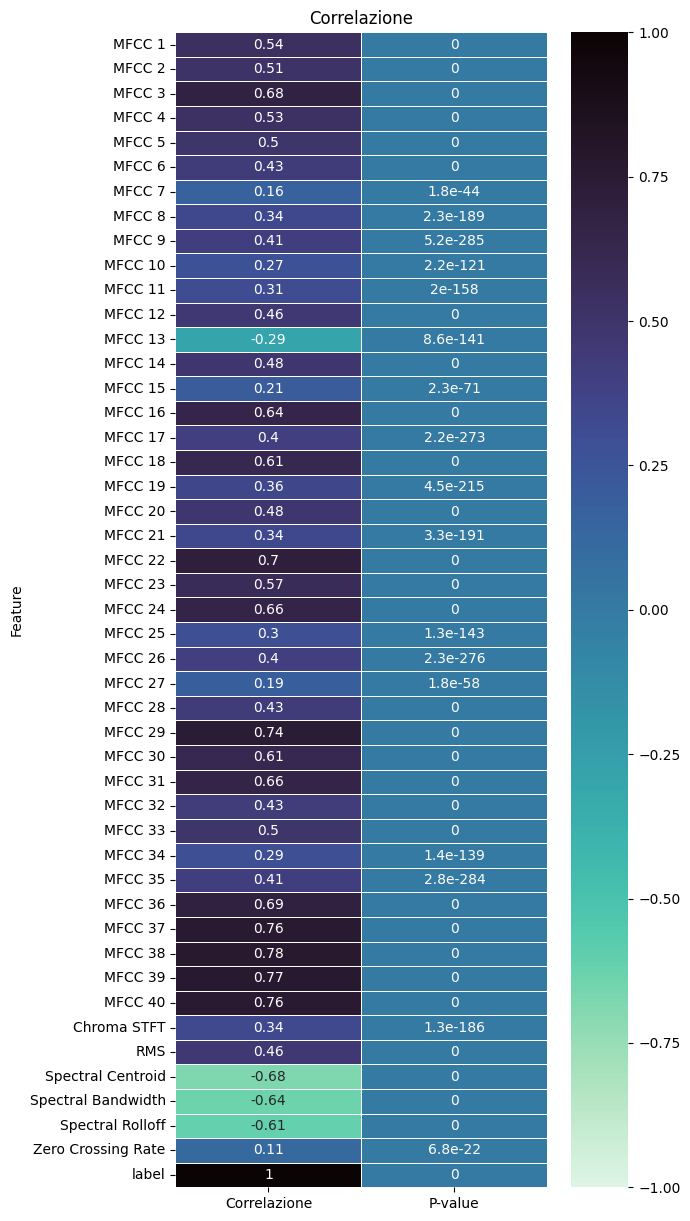

In [6]:
from scipy.stats import spearmanr
import seaborn as sns

# Importa le librerie necessarie
p_values = []
correlazione = []
features = []
# Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
for col1 in data_df.columns:
    correlation, p_value = spearmanr(data_df[col1], data_df["label"])
    p_values.append(p_value)
    correlazione.append(correlation)
    features.append(col1)

correlazione_df = pd.DataFrame(
    {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
)

correlazione_df.set_index("Feature", inplace=True)
plt.figure(figsize=(6, 15))
sns.heatmap(correlazione_df, annot=True, cmap="mako_r", linewidths=0.5, vmax=1, vmin=-1)
plt.title("Correlazione")
plt.show()

Remove features with low correlation with the target variable.

In [7]:
features_to_drop = correlazione_df[np.abs(correlazione_df["Correlazione"]) <= 0.41].index
print(features_to_drop)
data_df.drop(columns=features_to_drop, inplace=True)
info_df.drop(columns=features_to_drop, inplace=True)

Index(['MFCC 7', 'MFCC 8', 'MFCC 9', 'MFCC 10', 'MFCC 11', 'MFCC 13',
       'MFCC 15', 'MFCC 17', 'MFCC 19', 'MFCC 21', 'MFCC 25', 'MFCC 26',
       'MFCC 27', 'MFCC 34', 'MFCC 35', 'Chroma STFT', 'Zero Crossing Rate'],
      dtype='object', name='Feature')


In [8]:
print(len(data_df.columns))
print(data_df.columns)

30
Index(['MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 12',
       'MFCC 14', 'MFCC 16', 'MFCC 18', 'MFCC 20', 'MFCC 22', 'MFCC 23',
       'MFCC 24', 'MFCC 28', 'MFCC 29', 'MFCC 30', 'MFCC 31', 'MFCC 32',
       'MFCC 33', 'MFCC 36', 'MFCC 37', 'MFCC 38', 'MFCC 39', 'MFCC 40', 'RMS',
       'Spectral Centroid', 'Spectral Bandwidth', 'Spectral Rolloff', 'label'],
      dtype='object')


#### Plot correlation matrix  
Since there are a lot of features, it's quite confusing and difficult to analyze the whole correlation matrix. So, whe split the covariance matrix into three parts: first 10 features, next 10 features, and the rest of the features, in all groups is present the target variable as the last column.


(7113, 30)
(7113, 11) (7113, 11) (7113, 10)


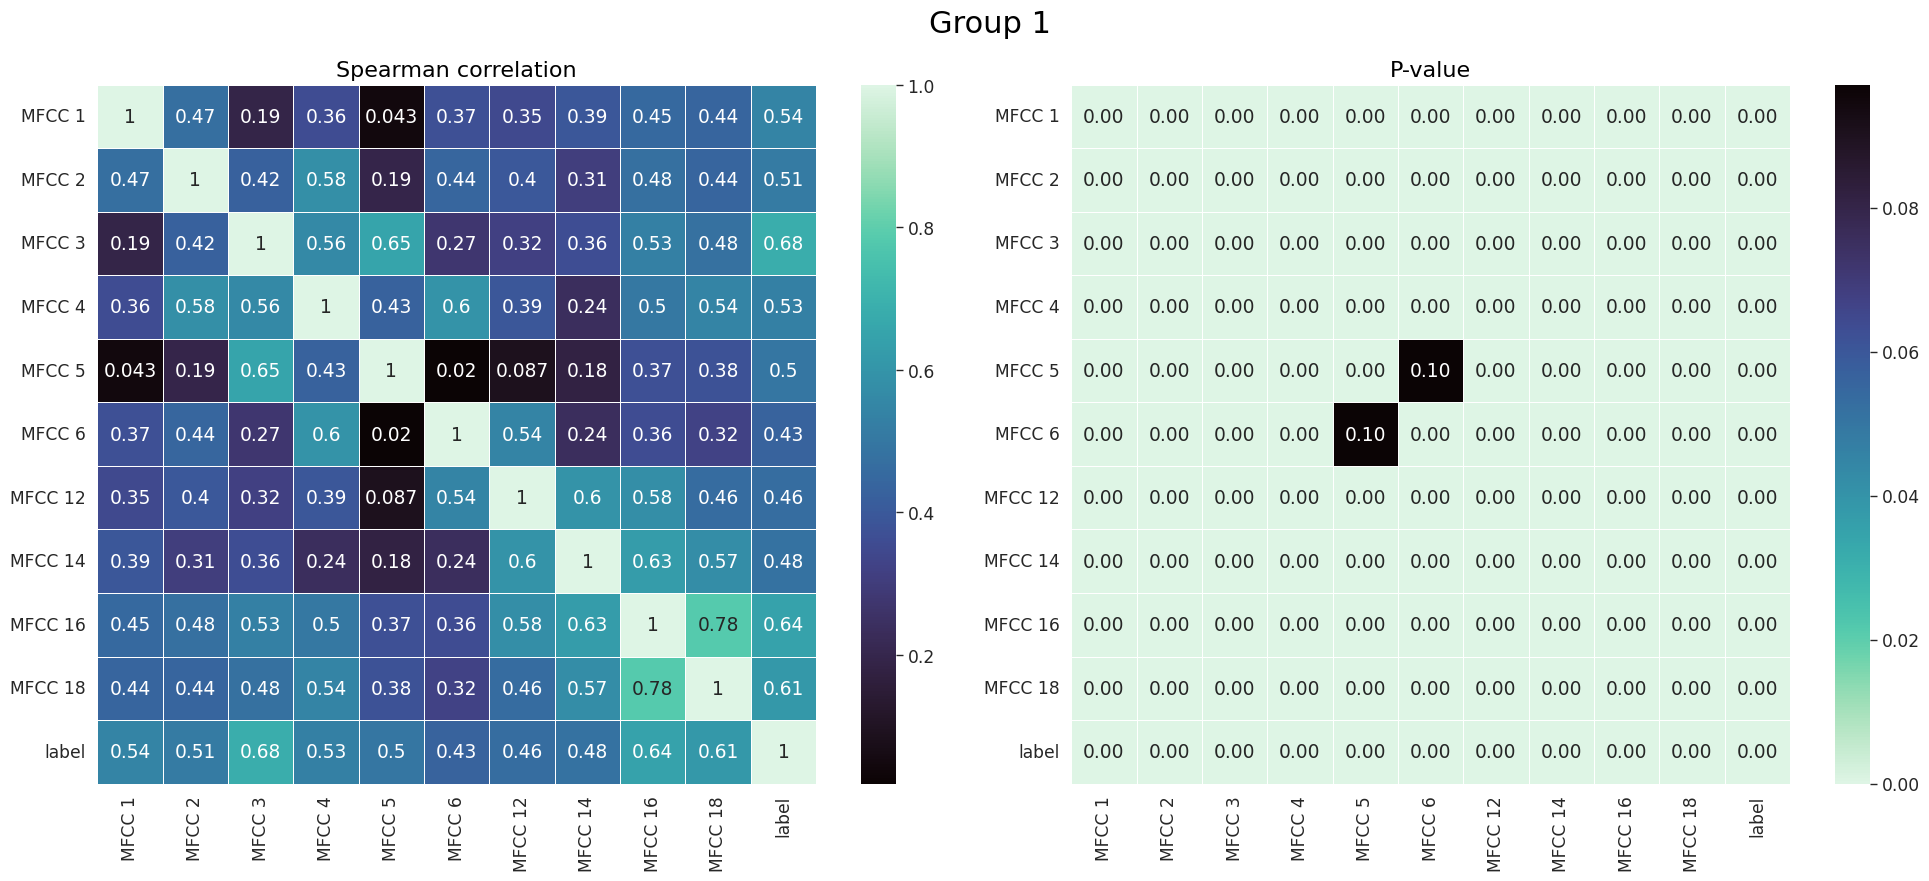

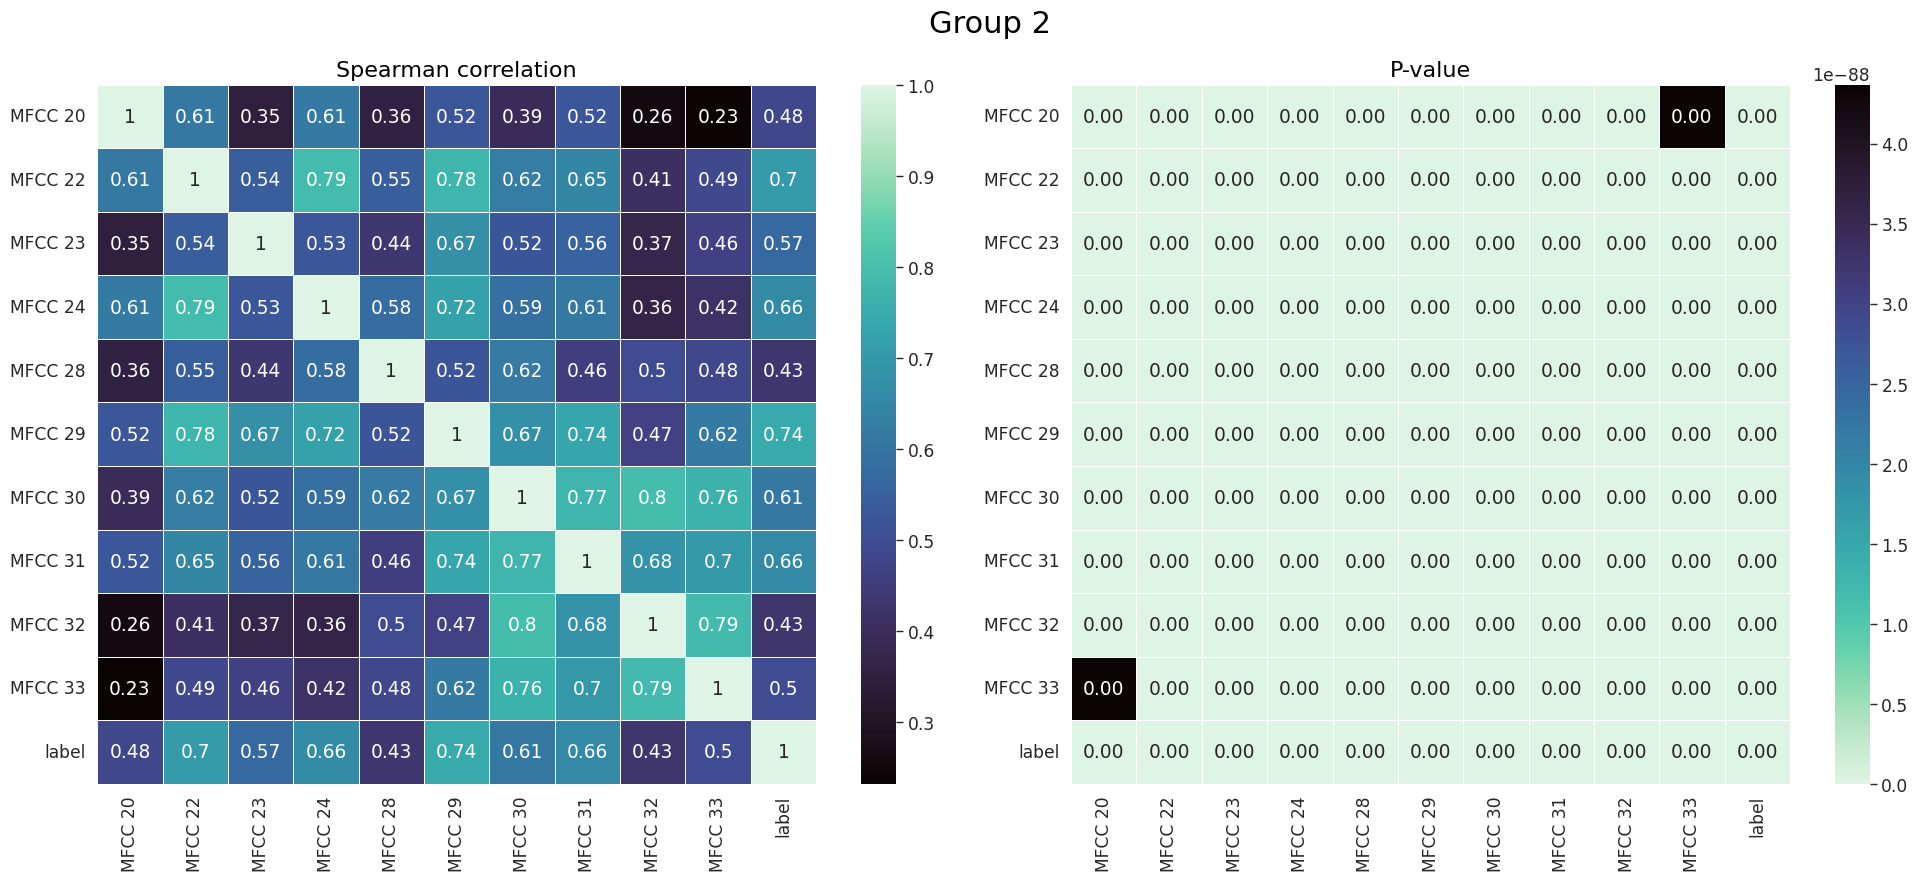

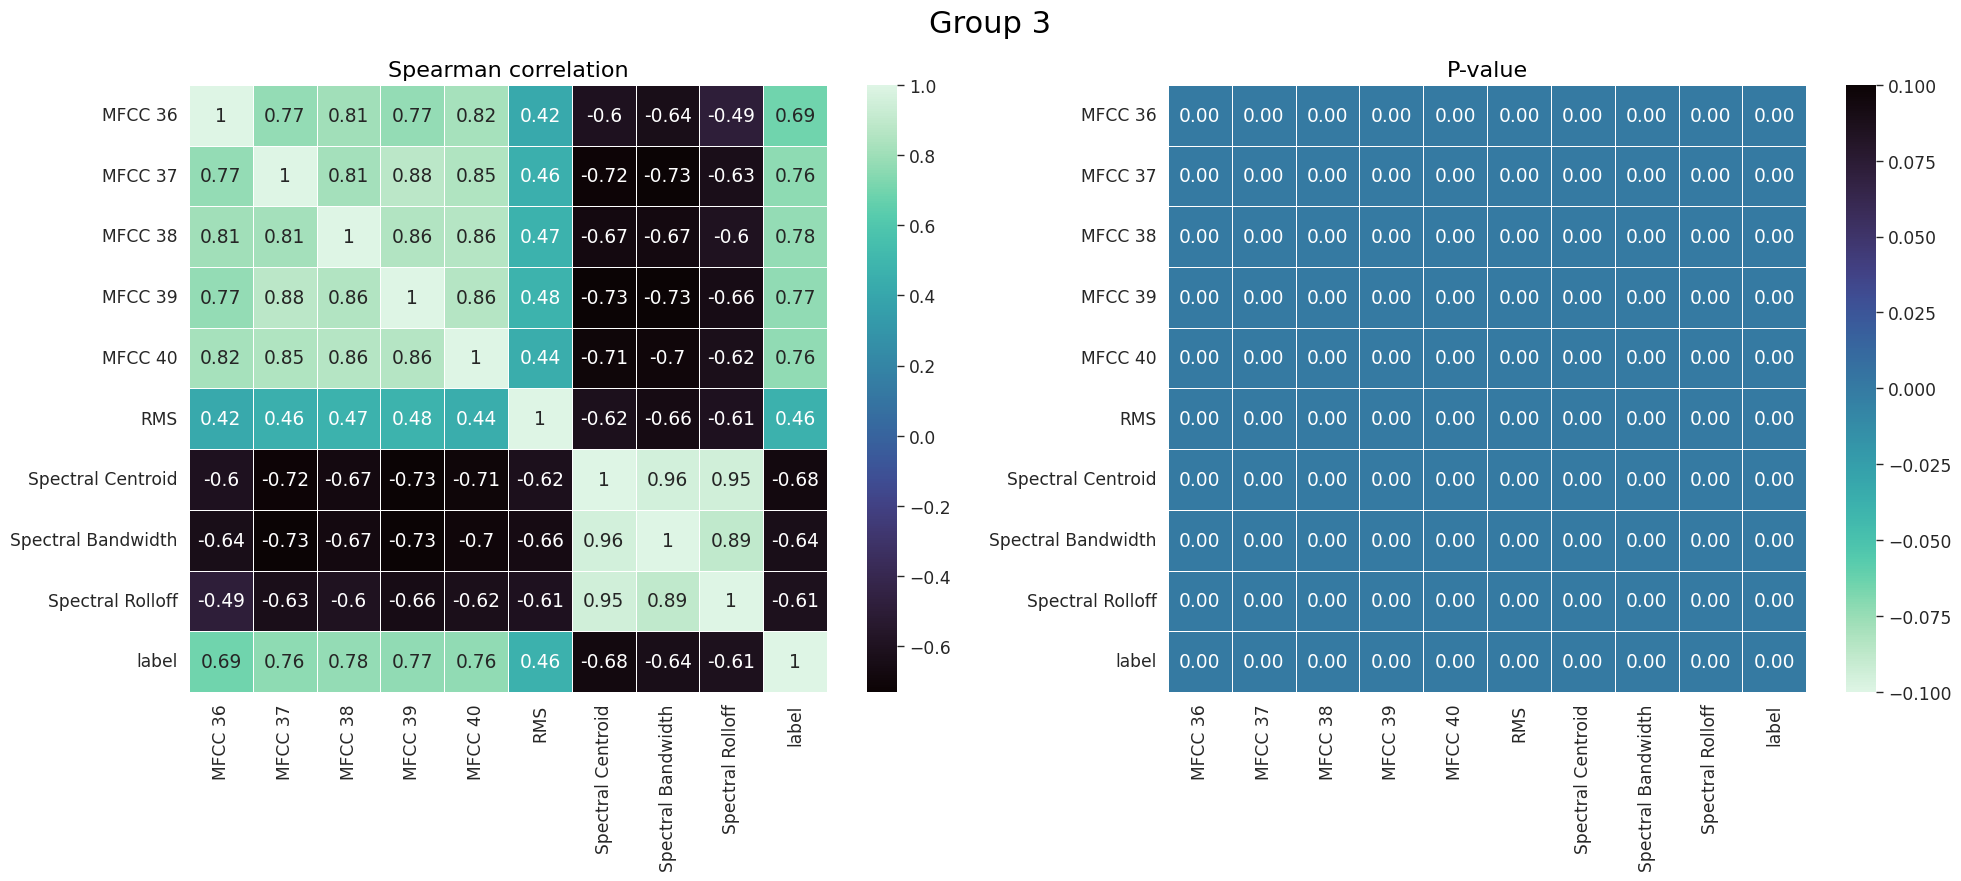

In [9]:
columns1, columns2, columns3, columns4 = split_col_groups(data_df.columns.to_list())

group1 = data_df[columns1]
group2 = data_df[columns2]
group3 = data_df[columns3]
print(data_df.shape)
print(group1.shape, group2.shape, group3.shape)
corr, pvalue = print_correlation(group1, "Group 1")
corr, pvalue = print_correlation(group2, "Group 2")
corr, pvalue = print_correlation(group3, "Group 3")
if columns4:
    group4 = data_df[columns4]
    corr, pvalue = print_correlation(group4, "Group 4")

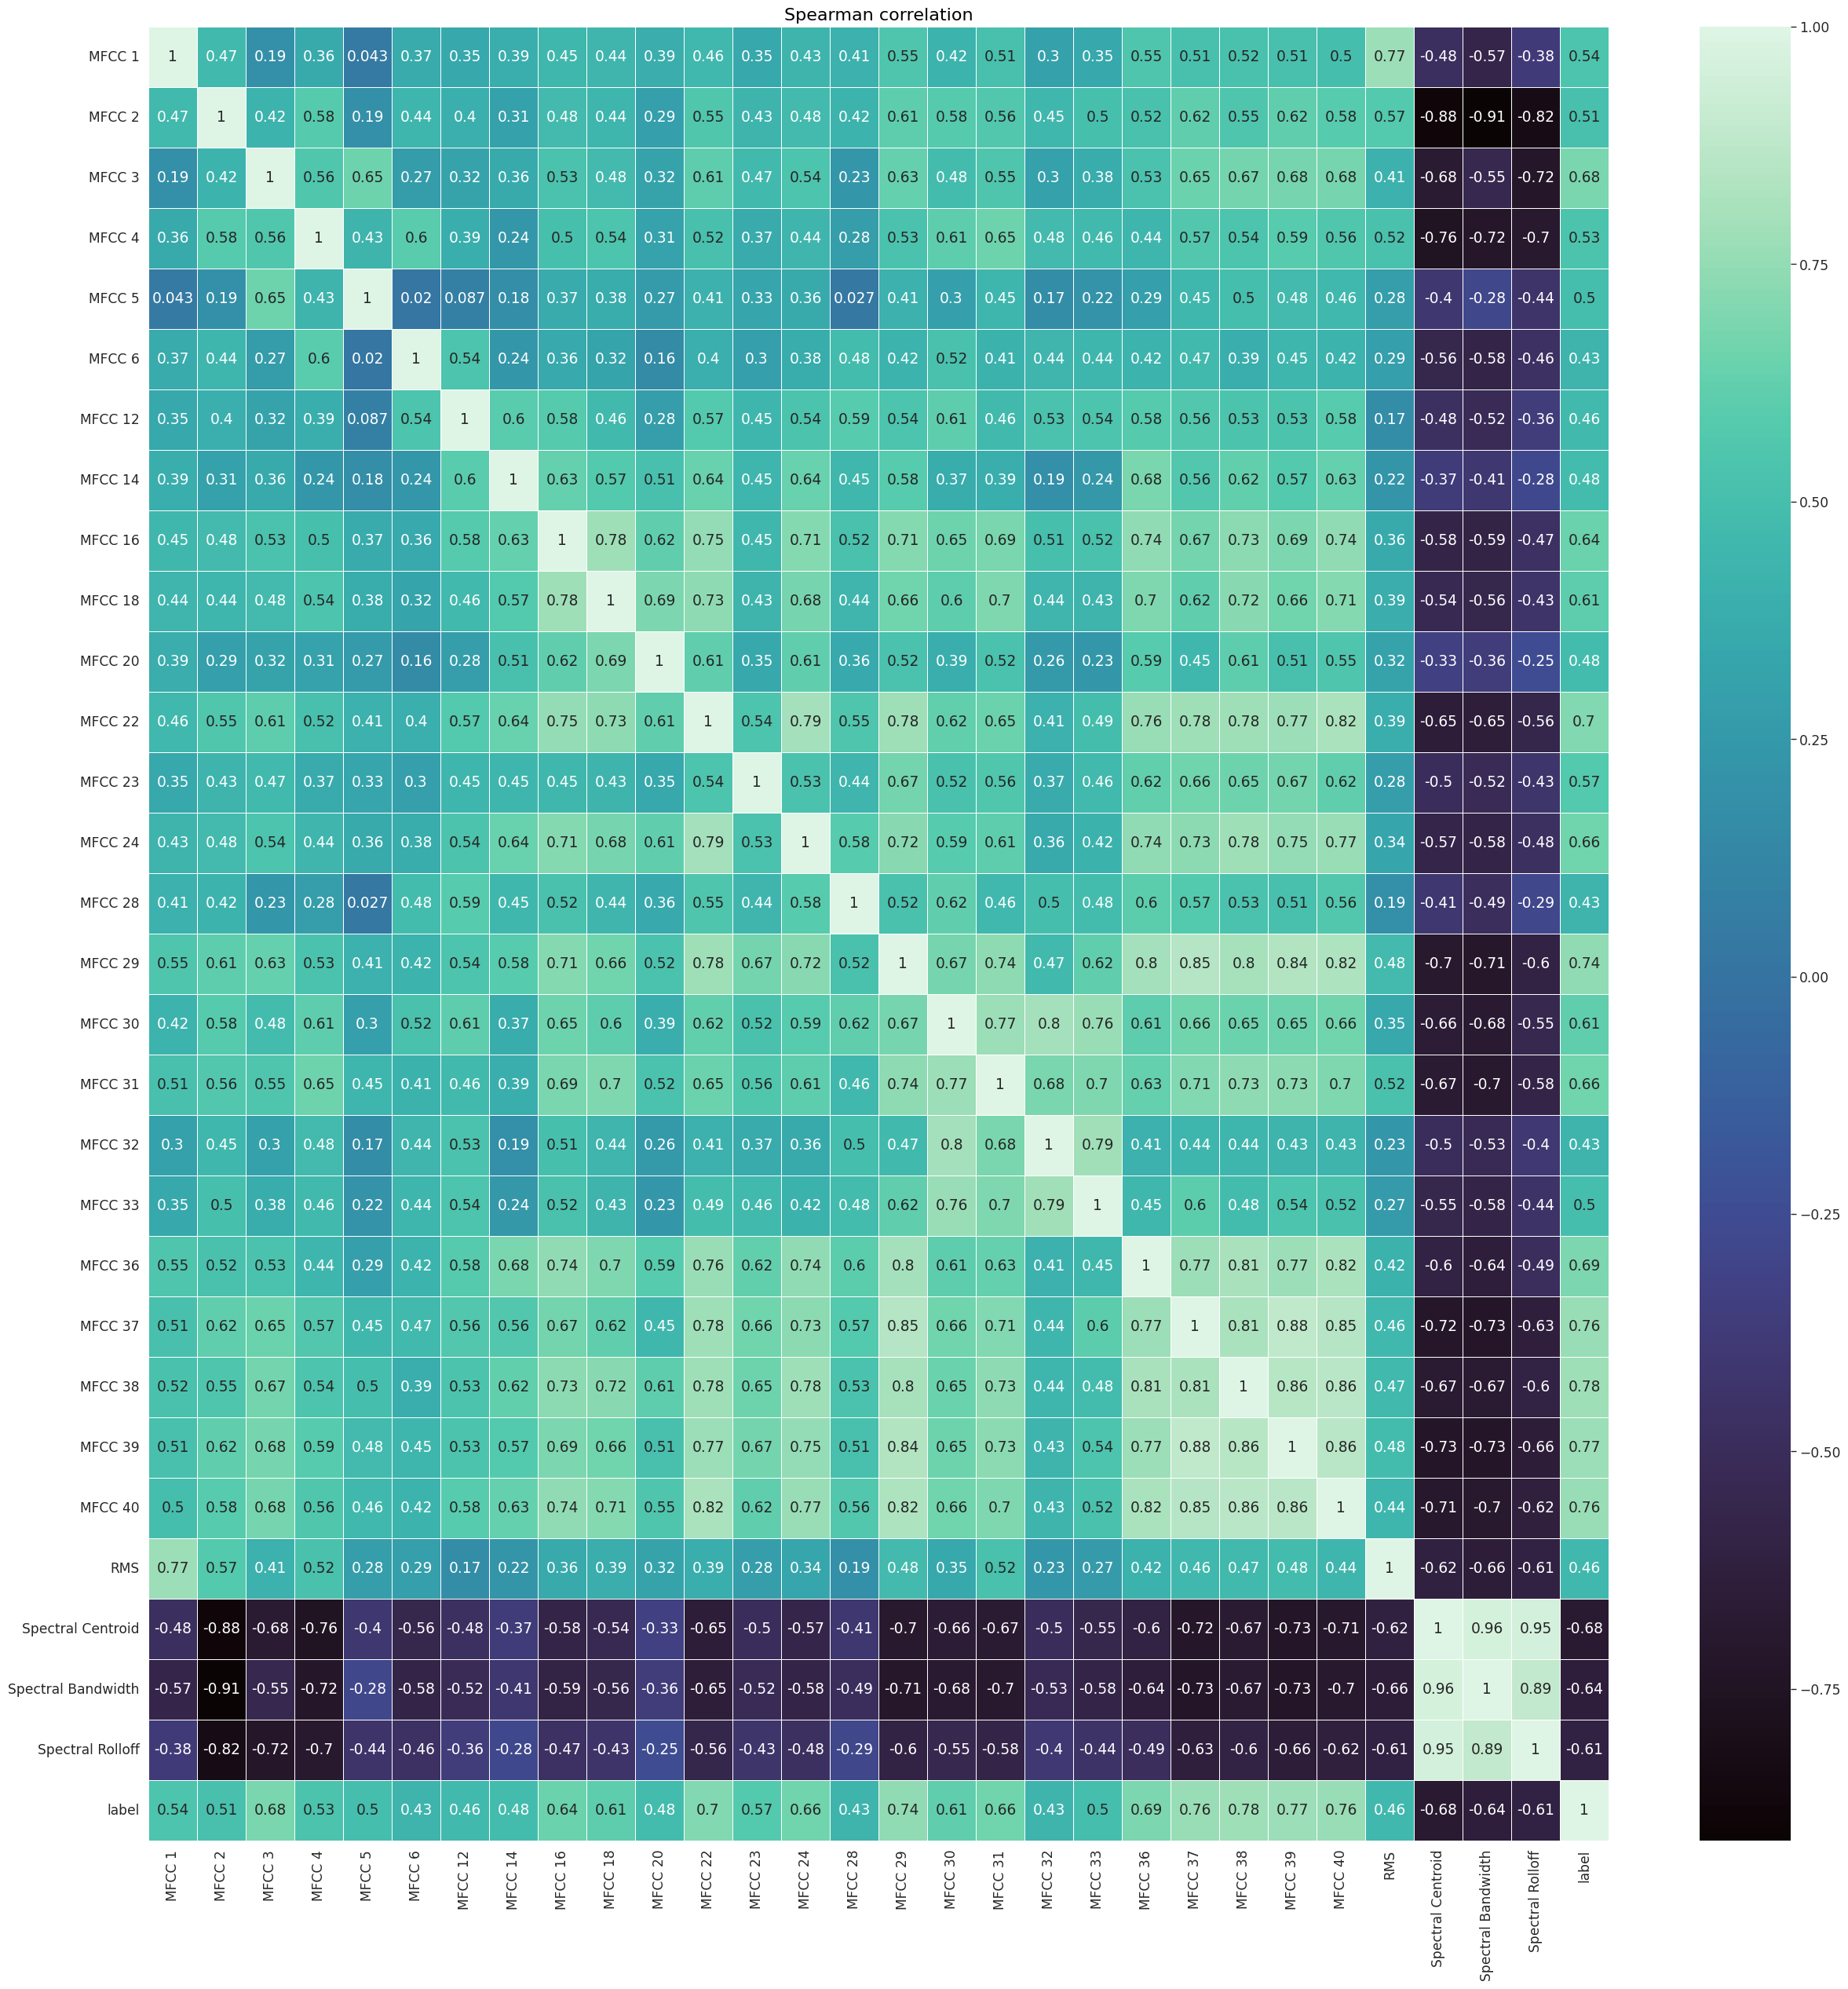

In [10]:
corr, pvalue = print_correlation(
    data_df, "All features", pvalue=False, figuresize=(30, 30)
)


### 3 covariance matrix of the groups

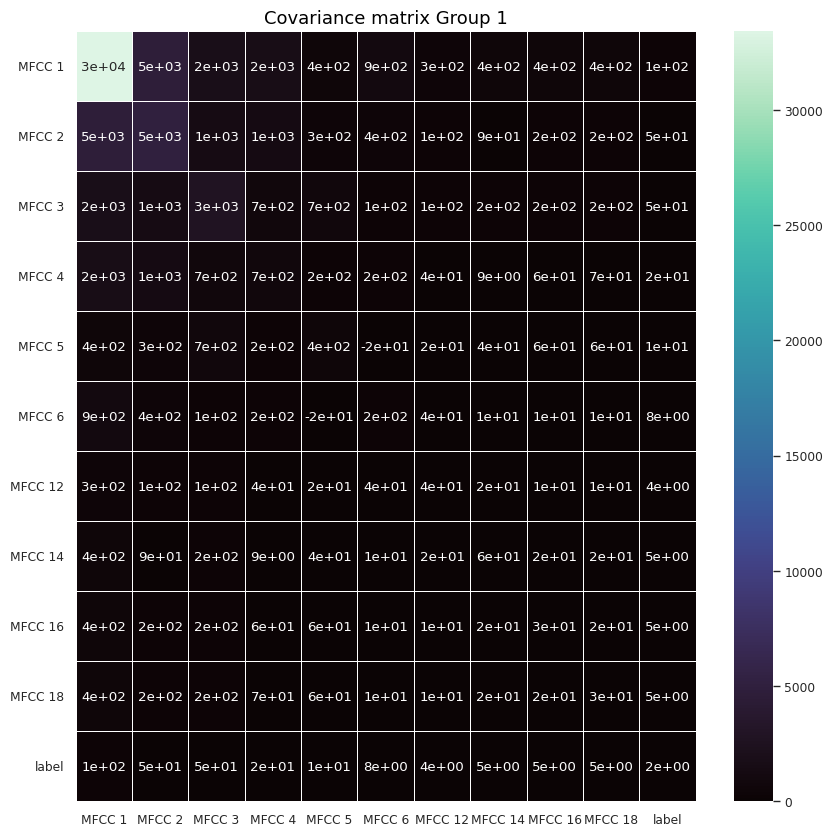

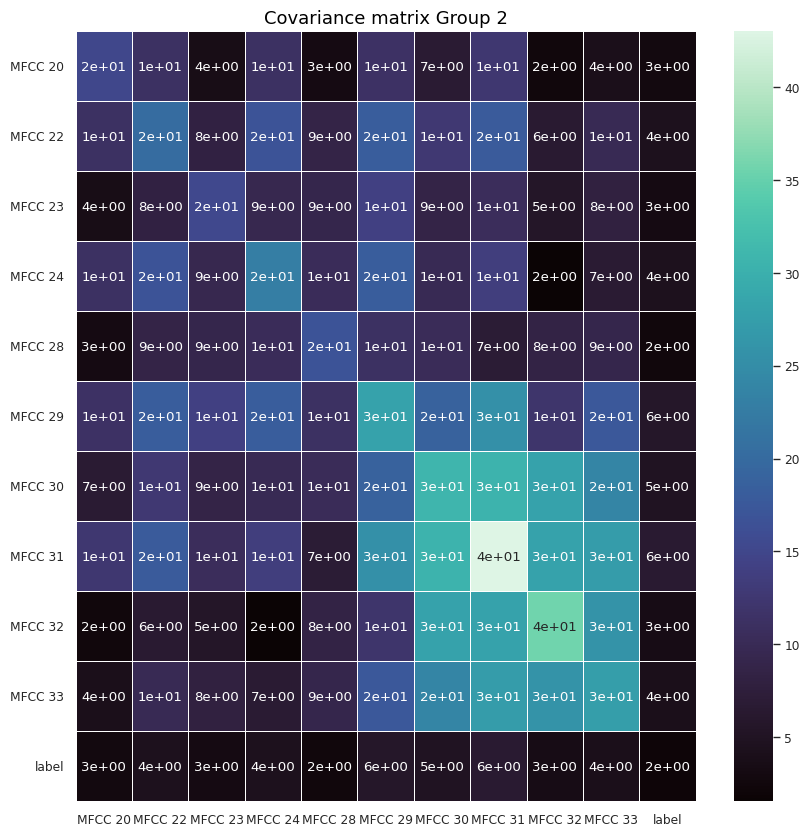

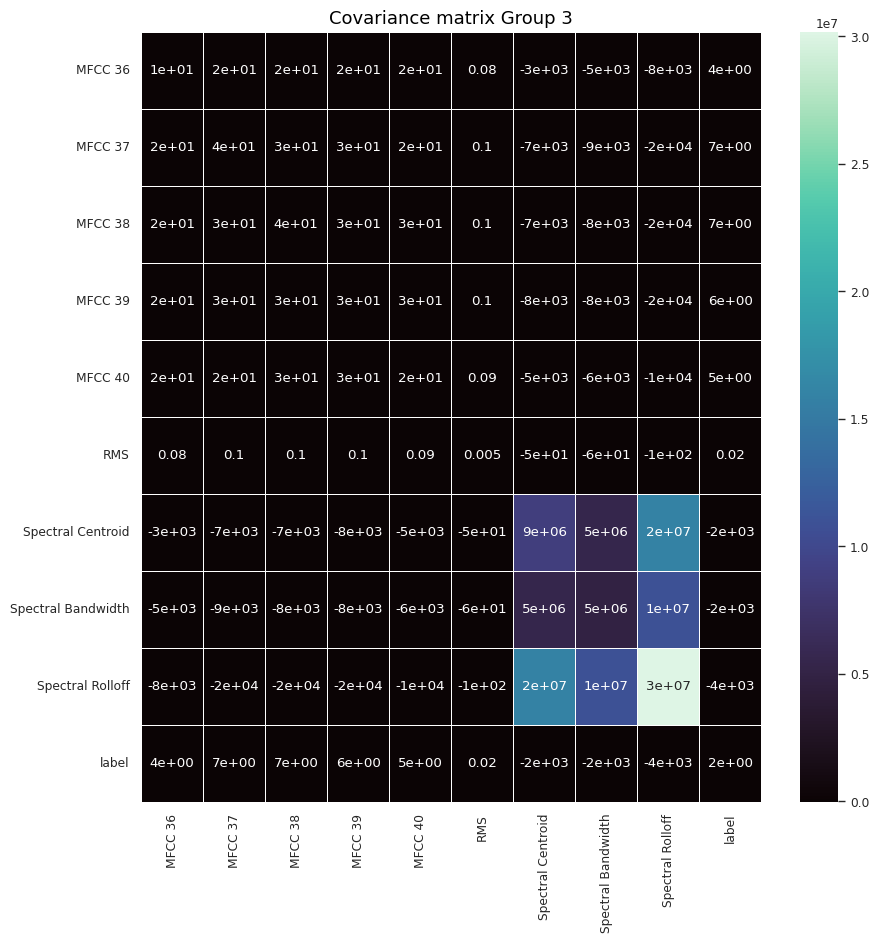

In [11]:
plt.figure(figsize=(10, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(group1.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.yticks(rotation=0)
plt.title("Covariance matrix Group 1", fontsize=13, color="black")
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(group2.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.title("Covariance matrix Group 2", fontsize=13, color="black")
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(group3.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.title("Covariance matrix Group 3", fontsize=13, color="black")
plt.yticks(rotation=0)
plt.show()

if columns4:
    plt.figure(figsize=(10, 10))
    sns.heatmap(group4.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
    plt.title("Covariance matrix Group 4", fontsize=13, color="black")
    plt.yticks(rotation=0)
    plt.show()

### 4 Feature Selection
Remove the features that are highly correlated with each other.
Like 'Spectral centroid' and 'Spectral bandwidth' and 'Spectral rolloff'

Removing 15 features
{'MFCC 29', 'MFCC 32', 'MFCC 18', 'MFCC 33', 'MFCC 30', 'MFCC 36', 'MFCC 24', 'MFCC 31', 'MFCC 39', 'Spectral Bandwidth', 'MFCC 37', 'MFCC 22', 'Spectral Rolloff', 'MFCC 16', 'MFCC 40'}


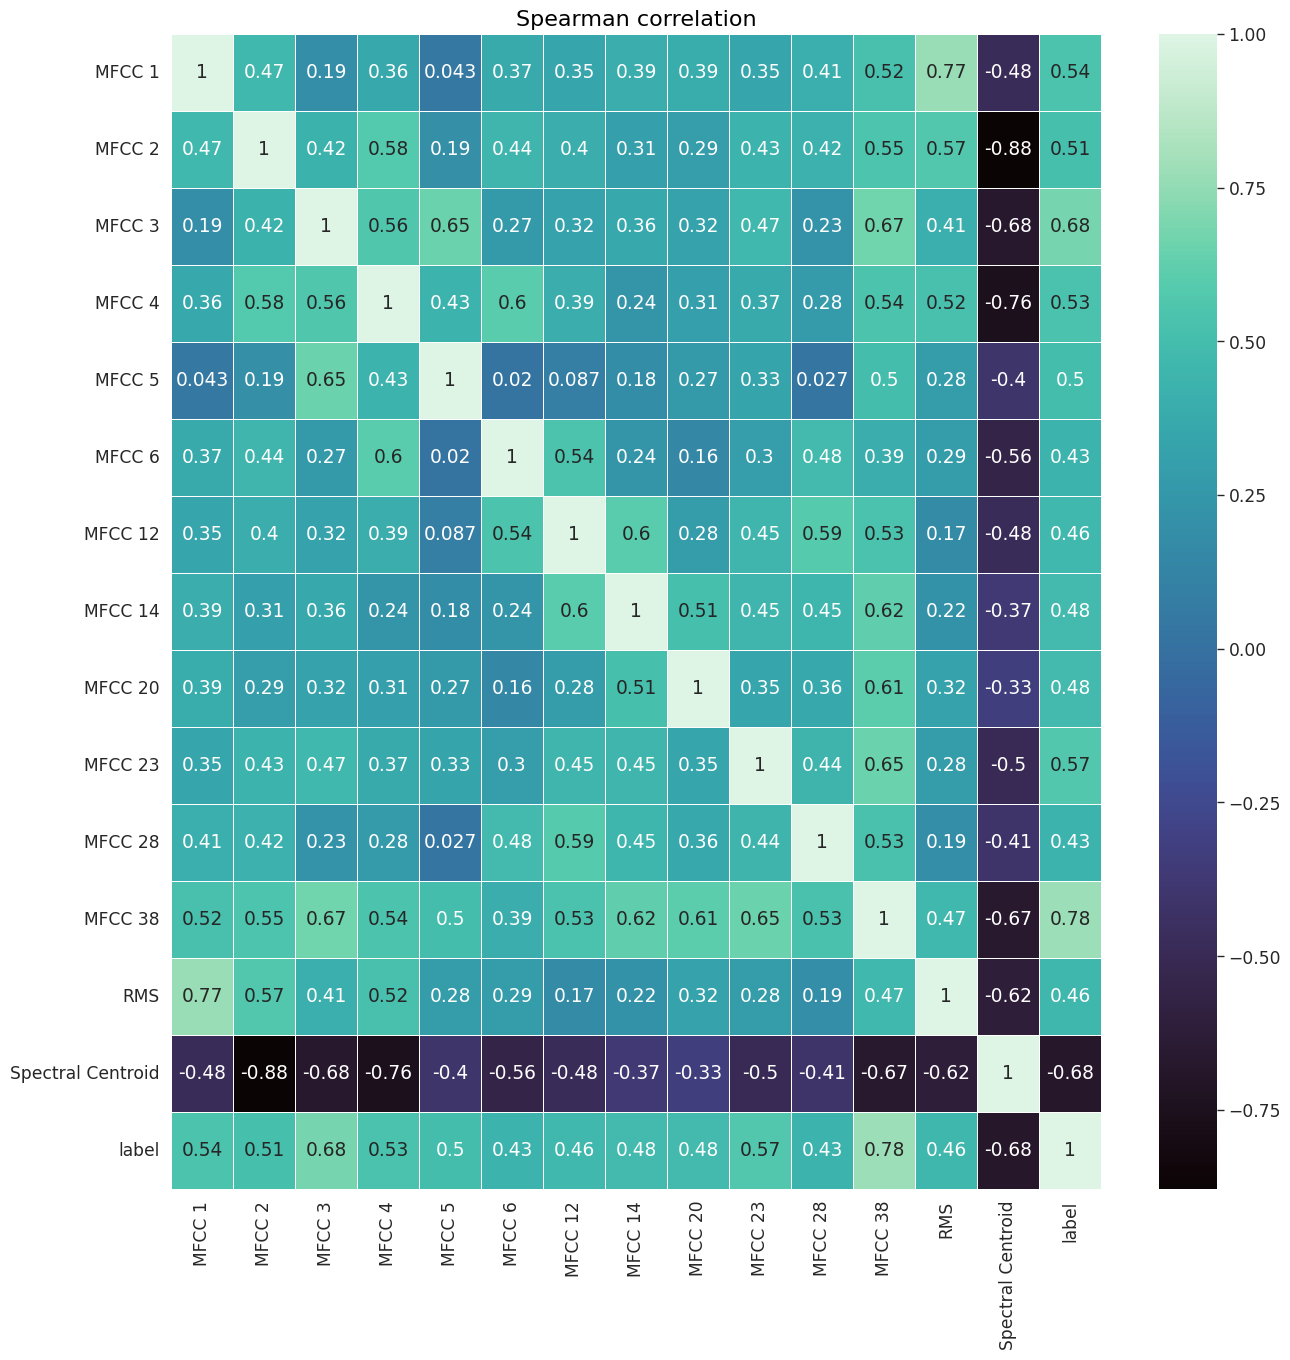

In [12]:
# Assuming your correlation matrix DataFrame is named 'correlation_matrix'

correlation_matrix = data_df.corr(method="spearman")
correlation_matrix_no_target = data_df.drop(columns=["label"]).corr(method="spearman")
relevant_features = remove_highly_correlated_features(
    correlation_matrix, correlation_matrix_no_target, threshold=0.7, max_corr_count=2
)

filtered_df = data_df[relevant_features]

corr, pvalue = print_correlation(
    filtered_df, "Filtered features", pvalue=False, figuresize=(15, 15)
)

### 5 Outliers Detection

In [13]:
outliers = detect_outliers_iqr(filtered_df,q1=0.10,q3=0.90)
outliers

MFCC 1     MFCC 2      MFCC 3     MFCC 4     MFCC 5     MFCC 6  \
22    21.819880  55.924706  -29.800133   9.916591 -10.512748  -8.182895   
179  -31.954180  42.681324  -21.319792  -6.604279 -27.286188 -11.900784   
1470 -87.081657  40.001873  -10.279896  -7.915582 -15.834297 -13.083798   
1762 -10.260093  48.197266  -20.644077  10.832644 -12.123764  -9.449729   
1763   9.364253  54.003510  -28.897141   5.610660 -13.053933  -8.165990   
...         ...        ...         ...        ...        ...        ...   
6872  67.714500 -76.469185 -115.774117 -54.276566 -22.091356  -7.575700   
6873  67.839432 -78.385254 -115.813599 -53.689953 -21.928087  -7.162486   
6874  68.951569 -79.490273 -115.154205 -51.503265 -21.968225  -7.979479   
6875  66.903656 -80.696281 -116.344978 -53.536880 -22.845600  -7.954034   
6953  44.518295 -65.024284 -117.362503 -51.373783 -19.214361  -7.473492   

        MFCC 12    MFCC 14   MFCC 20   MFCC 23   MFCC 28    MFCC 38       RMS  \
22    -1.429282  -7.764313 -3.155201 -0.556062  0.937372  -0.488579  0.574451   
179   30.673717 -19.852926  3.026474 -1.255130 -1.173733   2.148359  0.648416   
1470 -23.266781  -1.447166 -6.606025  3.302277 -2.317955   0.277816  0.572086   
1762   7.800878  -9.868224  5.097941 -0.031306  1.153988  -2.749442  0.621783   
1763   4.241856  -4.931680 -2.403481  0.133048  1.723263  -2.527887  0.567922   
...         ...        ...       ...       ...       ...        ...       ...   
6872  -5.798218  -2.774472 -5.390659 -9.180683 -4.650485 -14.808246  0.481872   
6873  -5.297607  -3.386951 -5.836564 -8.477181 -3.735932 -14.186712  0.480387   
6874  -5.796369  -2.984258 -6.741918 -9.151435 -4.044483 -14.390106  0.474319   
6875  -5.945668  -2.337885 -6.123292 -9.018892 -4.259621 -14.410052  0.471721   
6953   0.471576   0.478622 -4.684553 -7.555342 -3.400643 -12.062076  0.407971   

      Spectral Centroid  label  
22           558.227433    3.0  
179          479.194110    3.0  
1470         560.747827    3.0  
1762         519.761410    3.0  
1763         541.671661    3.0  
...                 ...    ...  
6872        5197.671393    0.0  
6873        5270.505987    0.0  
6874        5336.860366    0.0  
6875        5351.884404    0.0  
6953        4979.905555    0.0  

[105 rows x 15 columns]

In [14]:
new_data_df = filtered_df.drop(outliers.index, axis=0)
info_df = info_df.drop(outliers.index, axis=0)
new_data_df.groupby("label")

print("class count before removing outliers")
class_counts = filtered_df["label"].value_counts()
print(class_counts)

print("class count after removing outliers")
class_counts = new_data_df["label"].value_counts()
print(class_counts)

class count before removing outliers
label
3.0    2161
0.0    2000
2.0    1149
1.0    1026
4.0     777
Name: count, dtype: int64
class count after removing outliers
label
3.0    2156
0.0    1900
2.0    1149
1.0    1026
4.0     777
Name: count, dtype: int64


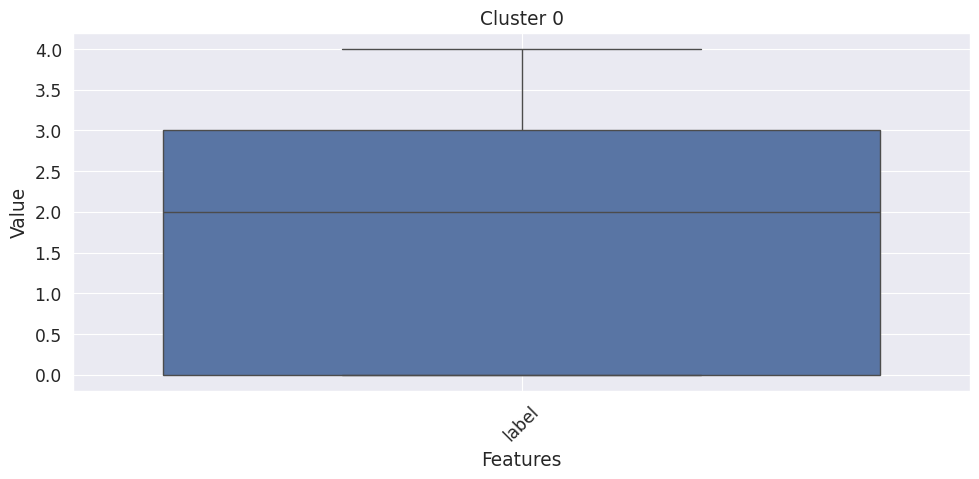

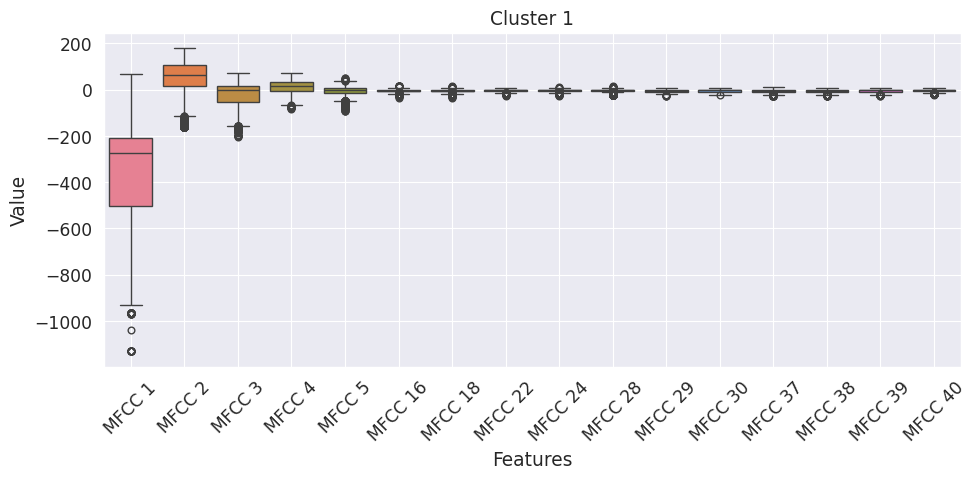

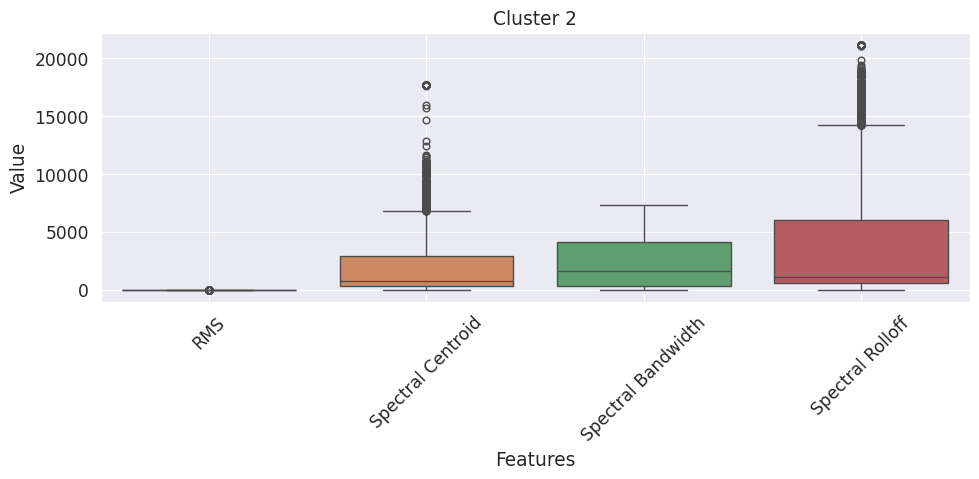

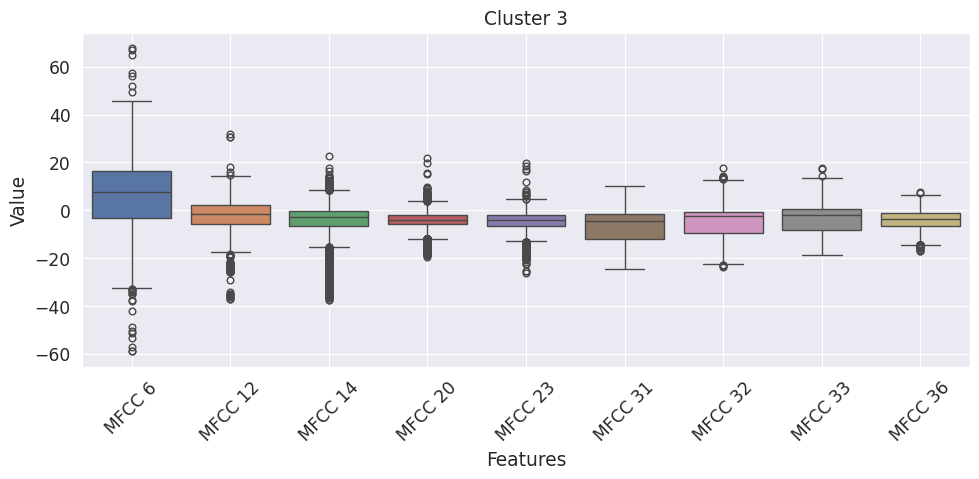

In [23]:
# Assuming data_df is your DataFrame containing the features
data_normalized = (data_df - data_df.min()) / (data_df.max() - data_df.min())
columns_info = data_normalized.describe().transpose()
columns_info["range"] = columns_info["max"] - columns_info["min"]
# Step 2: Cluster the features based on their ranges
kmeans = KMeans(
    n_clusters=4
)  # You can adjust the number of clusters as per your requirement
columns_info["cluster"] = kmeans.fit_predict(
    columns_info.values
)

# Step 3: Plot box plots for each cluster
for cluster_id in range(columns_info["cluster"].nunique()):
    plt.figure(figsize=(10, 5))
    columns = columns_info[columns_info["cluster"] == cluster_id].index
    cluster_data = data_df[columns]
    sns.boxplot(data=cluster_data, showfliers=True)
    plt.title(f"Cluster {cluster_id}")
    plt.xlabel("Features")
    plt.ylabel("Value")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 6 Feature Distribution

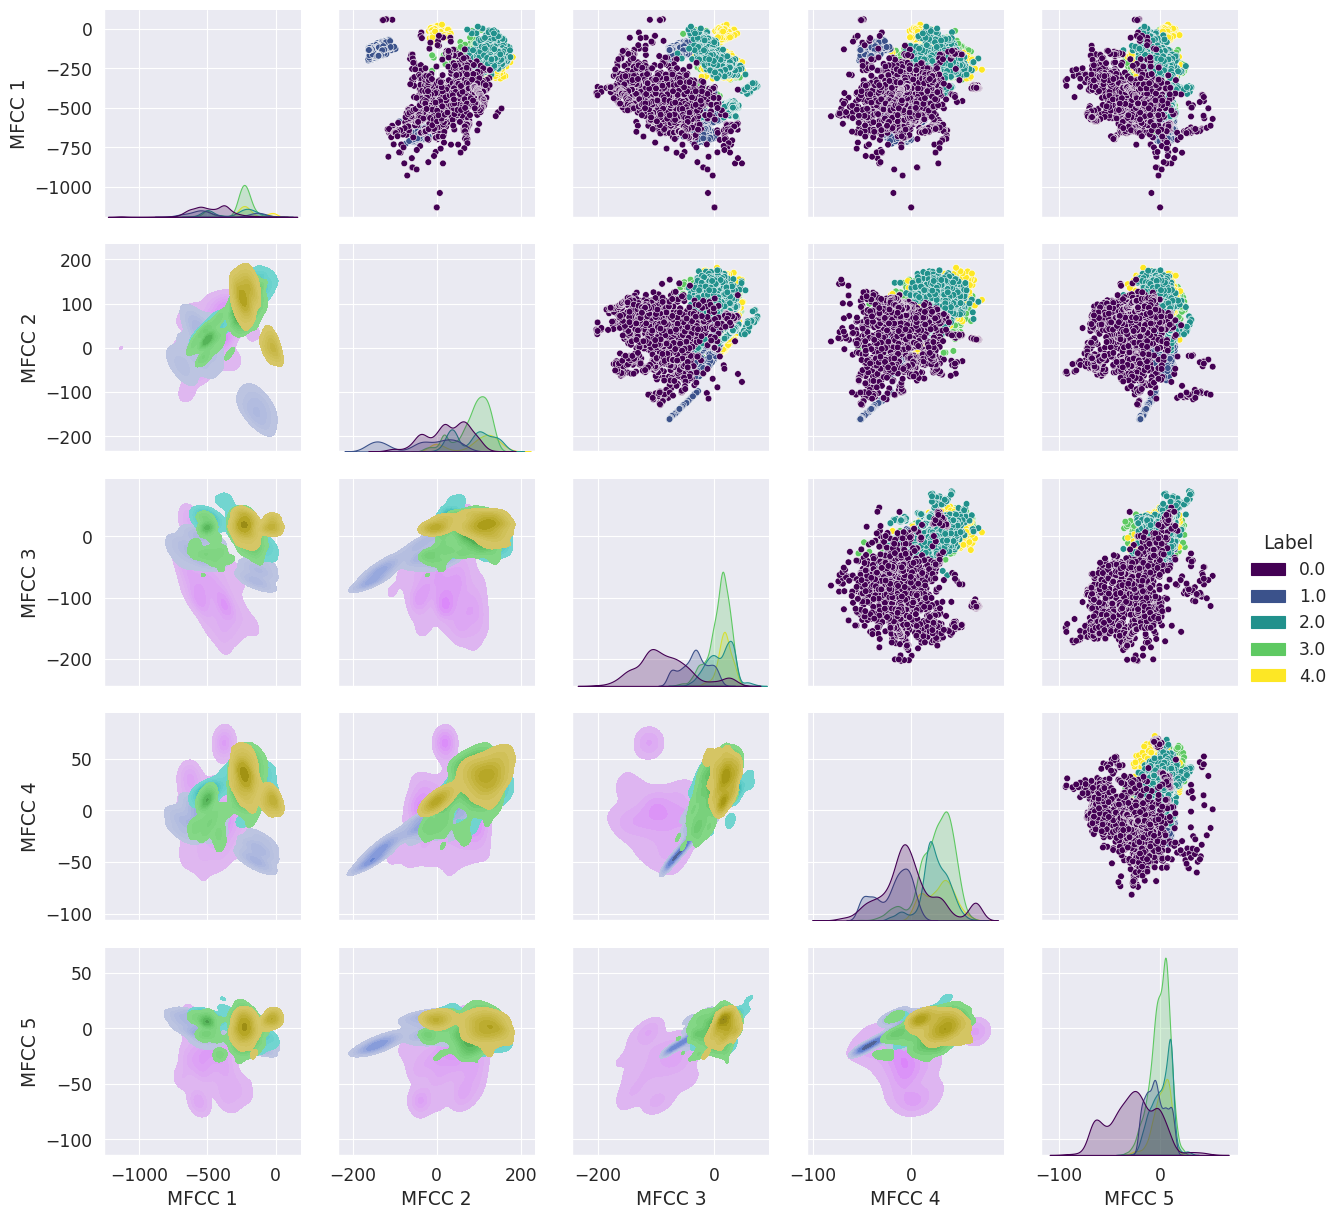

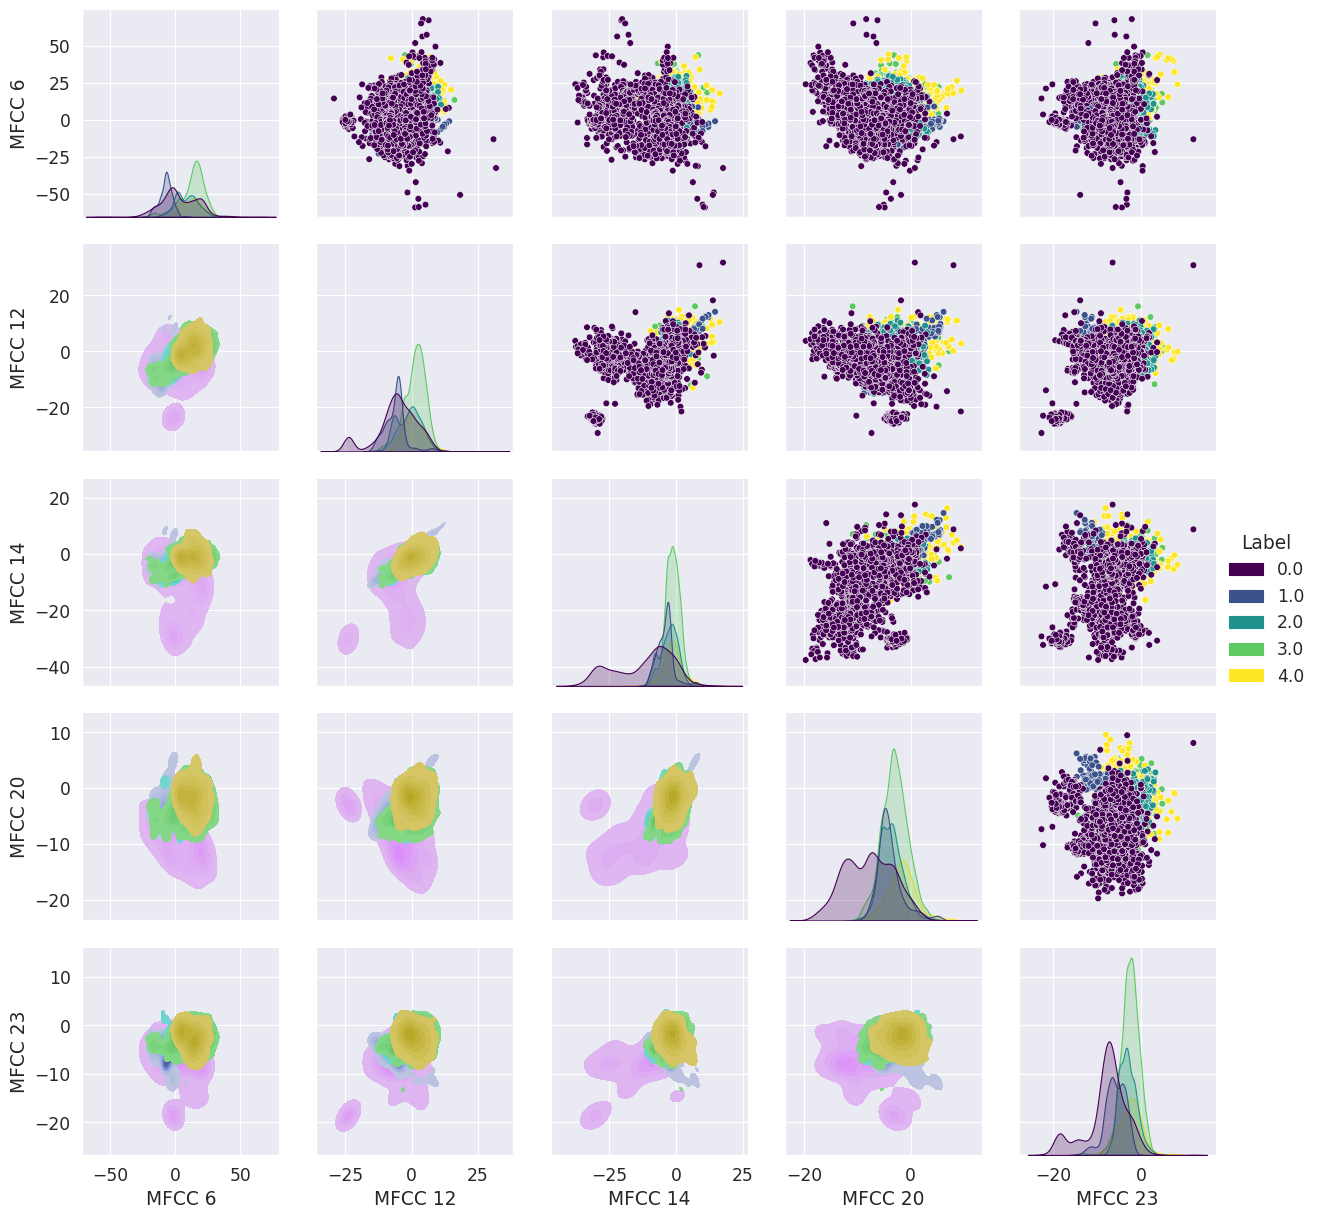

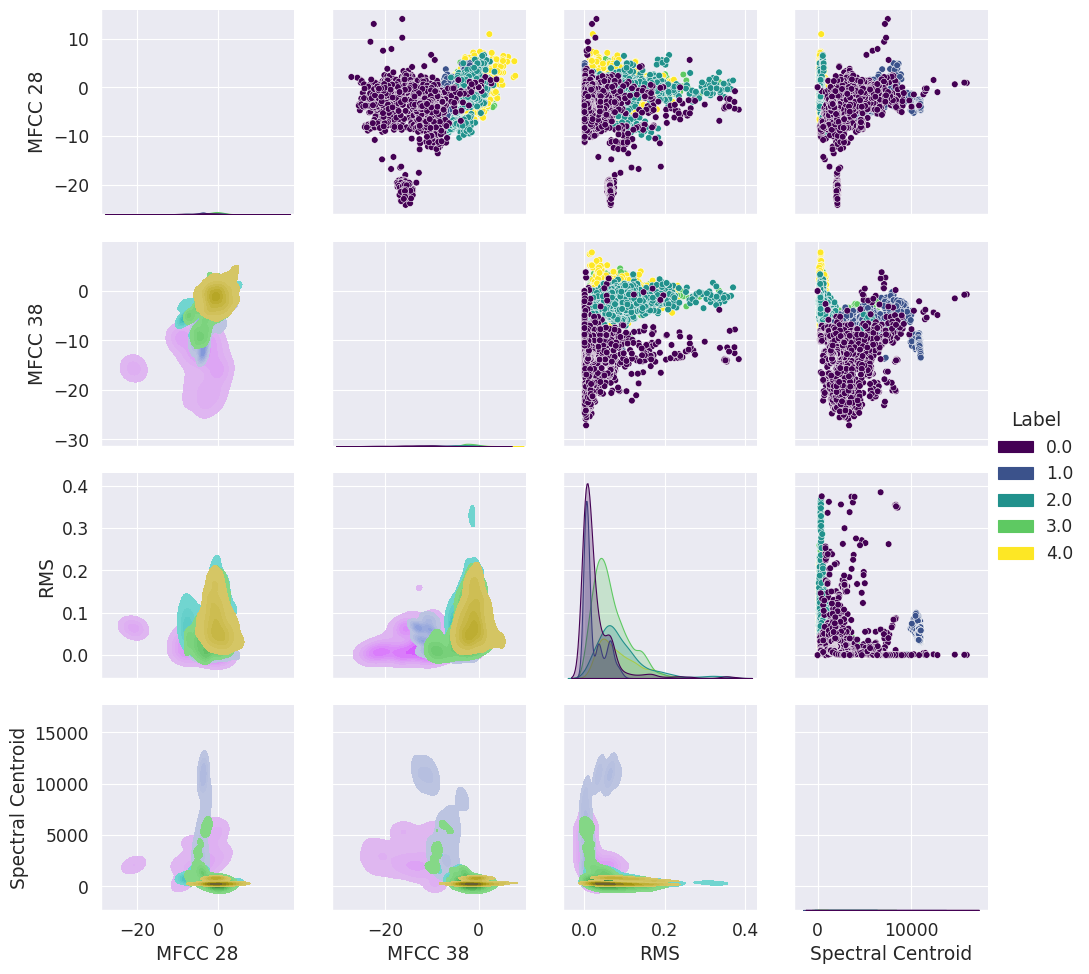

In [ ]:
columns1, columns2, columns3, columns4 = split_col_groups(new_data_df.columns.tolist())

group1 = new_data_df[columns1]
group2 = new_data_df[columns2]
group3 = new_data_df[columns3]


g = sns.PairGrid(group1, hue="label", palette="viridis")
g.map_upper(sns.scatterplot)
g.map_lower(
    sns.kdeplot,
    fill=True,
)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend(title="Label")
plt.show()

g = sns.PairGrid(group2, hue="label", palette="viridis")
g.map_upper(sns.scatterplot)
g.map_lower(
    sns.kdeplot,
    fill=True,
)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend(title="Label")
plt.show()

g = sns.PairGrid(group3, hue="label", palette="viridis")
g.map_upper(sns.scatterplot)
g.map_lower(
    sns.kdeplot,
    fill=True,
)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend(title="Label")
plt.show()

if columns4:
    group4 = data_df[columns4]
    g = sns.PairGrid(group4, hue="label", palette="viridis")
    g.map_upper(sns.scatterplot)
    g.map_lower(
        sns.kdeplot,
        fill=True,
    )
    g.map_diag(sns.kdeplot, fill=True)
    g.add_legend(title="Label")
    plt.show()

### 8. Save Data

In [ ]:
data = info_df.values

if not os.path.exists(NEW_FEATURES_DIR):
    os.makedirs(NEW_FEATURES_DIR)

for label in info_df["label"].unique():
    class_name= name_labels[label]
    name = f"{label}_filtered.npz"
    np.savez_compressed(NEW_FEATURES_DIR + name, X=data[:, :-2], y=data[:, -2], filename=data[:, -1])